# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В нашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Нам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.
<br>
Значение метрики RMSE должно быть меньше 2500.


# Краткий план выполнения проекта:
Загрузим данные.<br>
Изучим данные. Заполним пропущенные значения и обработаем аномалии в столбцах. Если среди признаков имеются неинформативные, удалим их.<br>
Подготовим выборки для обучения моделей.<br>
Обучим разные модели, одна из которых — LightGBM, как минимум одна — не бустинг.<br>
Проанализируем время обучения, время предсказания и качество моделей.<br>
Опираясь на критерии заказчика, выберем лучшую модель.<br>

# Описание данных
Признаки:<br>
<br>
DateCrawled — дата скачивания анкеты из базы <br>
VehicleType — тип автомобильного кузова<br>
RegistrationYear — год регистрации автомобиля<br>
Gearbox — тип коробки передач<br>
Power — мощность (л. с.)<br>
Model — модель автомобиля<br>
Kilometer — пробег (км)<br>
RegistrationMonth — месяц регистрации автомобиля<br>
FuelType — тип топлива<br>
Brand — марка автомобиля<br>
Repaired — была машина в ремонте или нет<br>
DateCreated — дата создания анкеты<br>
NumberOfPictures — количество фотографий автомобиля<br>
PostalCode — почтовый индекс владельца анкеты (пользователя)<br>
LastSeen — дата последней активности пользователя<br>
Целевой признак:<br>
<br>
Price — цена (евро)

Установим необходимый функционал и импортируем нееобходимые библиотеки.

In [10]:
pip install --upgrade pip -q

Note: you may need to restart the kernel to use updated packages.


In [11]:
!pip install phik -q

In [12]:
!pip install scikit-learn==1.3.2 -q

In [13]:
!pip install missingno -q

In [14]:
# импортируем все необходимые библиотеки 
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as st
import missingno as msno
from sklearn.inspection import permutation_importance
import phik
from numpy import quantile
from sklearn.dummy import DummyRegressor
import warnings
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler, RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.model_selection import RandomizedSearchCV , GridSearchCV
from sklearn.svm import SVC
from sklearn.impute import SimpleImputer
from lightgbm import LGBMRegressor
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LogisticRegression, LinearRegression, Ridge, Lasso
from sklearn.metrics import (mean_squared_error, mean_absolute_error, confusion_matrix,
                             accuracy_score, precision_score, recall_score, r2_score, roc_auc_score, make_scorer)
RANDOM_STATE = 42
TEST_SIZE = 0.2

## Подготовка данных

Сохраним в переменную таблицу с данными.

In [6]:
data = pd.read_csv('/####.csv')
data.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


Взглянем на общую информацию о таблице.

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

Видим, что формат данных соответствует истеному во всех столбцах, кроме DateCrawled.

Проверим кол-во явных дубликатов.

In [8]:
data.duplicated().sum()

4

In [9]:
data[data.duplicated() == True]

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
171088,2016-03-08 18:42:48,1799,coupe,1999,auto,193,clk,20000,7,petrol,mercedes_benz,no,2016-03-08 00:00:00,0,89518,2016-03-09 09:46:57
231258,2016-03-28 00:56:10,1000,small,2002,manual,83,other,150000,1,petrol,suzuki,no,2016-03-28 00:00:00,0,66589,2016-03-28 08:46:21
258109,2016-04-03 09:01:15,4699,coupe,2003,auto,218,clk,125000,6,petrol,mercedes_benz,yes,2016-04-03 00:00:00,0,75196,2016-04-07 09:44:54
325651,2016-03-18 18:46:15,1999,wagon,2001,manual,131,passat,150000,7,gasoline,volkswagen,no,2016-03-18 00:00:00,0,36391,2016-03-18 18:46:15


In [10]:
data = data.drop_duplicates()
data.duplicated().sum()

0

Всего 4 явных дубликата. Удалили их.

In [11]:
date = pd.to_datetime(data['DateCrawled'])
date.max()

Timestamp('2016-04-07 14:36:58')

Проверили верхнюю границу даты регистрации автомобиля. Это пригодиться в дальнейшем, чтобы определить выбросы в годе производства машины.

Удалим не информативные столбцы.

In [12]:
data = data.drop(columns=['DateCrawled', 'RegistrationMonth', 'DateCreated', 'PostalCode', 'LastSeen', 'NumberOfPictures'],
        inplace=False,
        errors='ignore')

Привеидем названия столбцов к нижнему регистру.

In [13]:
data.columns = data.columns.str.lower()
data.columns = data.columns.str.replace('vehicletype','vehicle_type')
data.columns = data.columns.str.replace('registrationyear','registration_year')
data.columns = data.columns.str.replace('fueltype','fuel_type')

Взглянем на итоговый вид таблицы и информацию о ней.

In [14]:
data.head()

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired
0,480,NaN,1993,manual,0,golf,150000,petrol,volkswagen,NaN
1,18300,coupe,2011,manual,190,NaN,125000,gasoline,audi,yes
2,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,NaN
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no


In [15]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 354365 entries, 0 to 354368
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   price              354365 non-null  int64 
 1   vehicle_type       316875 non-null  object
 2   registration_year  354365 non-null  int64 
 3   gearbox            334532 non-null  object
 4   power              354365 non-null  int64 
 5   model              334660 non-null  object
 6   kilometer          354365 non-null  int64 
 7   fuel_type          321470 non-null  object
 8   brand              354365 non-null  object
 9   repaired           283211 non-null  object
dtypes: int64(4), object(6)
memory usage: 29.7+ MB


Проверим наличие пропусков и как они расспределены в таблице.

In [16]:
data.isna().sum()

price                    0
vehicle_type         37490
registration_year        0
gearbox              19833
power                    0
model                19705
kilometer                0
fuel_type            32895
brand                    0
repaired             71154
dtype: int64

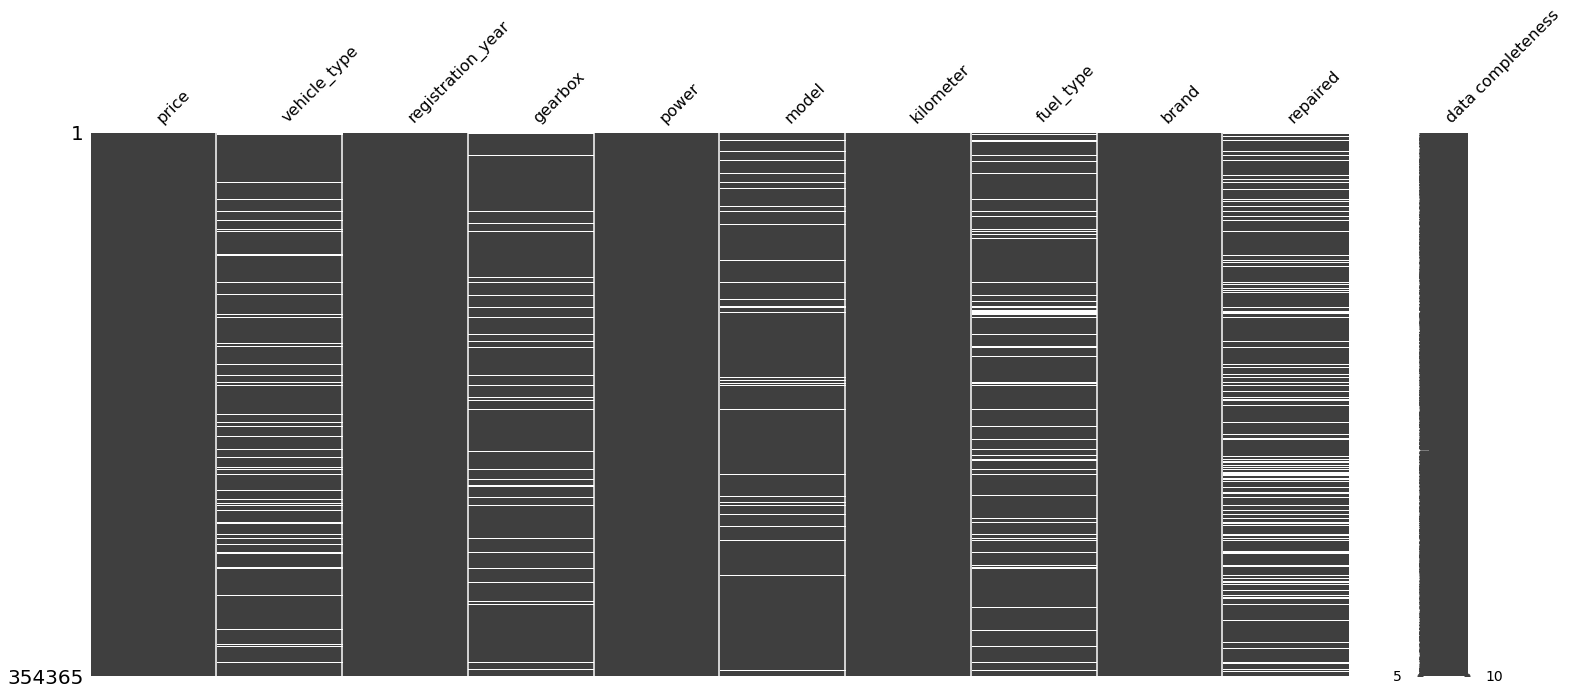

In [17]:
msno.matrix(data, labels=True)
plt.show()

В таблице большое кол-во пропусков в столбцах с типом кузова, типом коробки передач, моделью машины, типом топлива и наличием ремонта. Благодаря визуализации, мы видем, что пропуски расспределенны равномерно по всей таблице. Обработкой пропусков займемся после разделения таблицы на тестовую и тренировочную выборки.

Далее взглянем на уникальные значения в категориальных столбцах.

In [18]:
data['vehicle_type'].unique()

array([nan, 'coupe', 'suv', 'small', 'sedan', 'convertible', 'bus',
       'wagon', 'other'], dtype=object)

In [19]:
data['gearbox'].unique()

array(['manual', 'auto', nan], dtype=object)

In [20]:
data['fuel_type'].unique() 

array(['petrol', 'gasoline', nan, 'lpg', 'other', 'hybrid', 'cng',
       'electric'], dtype=object)

"cng" и "lpg" это тоже газовое топливо, поэтому заменили значения.

In [21]:
data['fuel_type'] = data['fuel_type'].str.replace('cng', 'gasoline')
data['fuel_type'] = data['fuel_type'].str.replace('lpg', 'gasoline')
data['fuel_type'].unique()

array(['petrol', 'gasoline', nan, 'other', 'hybrid', 'electric'],
      dtype=object)

In [22]:
data['brand'].unique()

array(['volkswagen', 'audi', 'jeep', 'skoda', 'bmw', 'peugeot', 'ford',
       'mazda', 'nissan', 'renault', 'mercedes_benz', 'opel', 'seat',
       'citroen', 'honda', 'fiat', 'mini', 'smart', 'hyundai',
       'sonstige_autos', 'alfa_romeo', 'subaru', 'volvo', 'mitsubishi',
       'kia', 'suzuki', 'lancia', 'toyota', 'chevrolet', 'dacia',
       'daihatsu', 'trabant', 'saab', 'chrysler', 'jaguar', 'daewoo',
       'porsche', 'rover', 'land_rover', 'lada'], dtype=object)

In [23]:
data['repaired'].unique()

array([nan, 'yes', 'no'], dtype=object)

### Вывод по подготовке данных.
1. Загрузили данные и провели первичное ознакомление.
2. Выяснили, что 2016 год - это ферхняя граница регистрации автомобилей, соотвественно в таблице должны быть автомобили производства до 2016 года.
3. Удалили 4 явных дубликата.
4. Убрали неинформативные столбцы.
5. Привели названия столбцов к нижнему регистру.
6. Обнаружили большое кол-во пропусков в таблице, их обработкой займемся после разбиения на тестовую и тренировочную выборки.
7. Проверили уникальные значения в категориальных столбцах. Заменили "cng" и "lpg" на "gasoline" т.к. это тоже газовое топливо.

## Исследовательский анализ.

Взглянем на статистику целевой переменной - price.

In [24]:
data['price'].describe()

count    354365.000000
mean       4416.679830
std        4514.176349
min           0.000000
25%        1050.000000
50%        2700.000000
75%        6400.000000
max       20000.000000
Name: price, dtype: float64

Уберем из таблицы записи с нулевым значением цены а также ноль пятый квантиль. Это слишком низкие цены для автомобиля.

In [25]:
data.drop(data[data['price'] == 0].index, inplace=True)

In [26]:
data.drop(data[data['price'] < data.price.quantile(.05)].index, inplace=True)

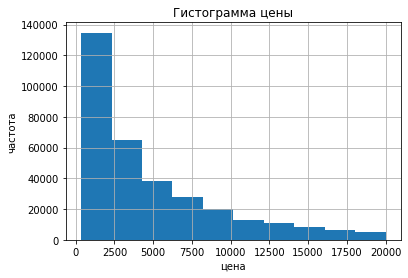

In [27]:
data['price'].hist()
plt.title('Гистограмма цены')
plt.ylabel('частота')
plt.xlabel('цена')
plt.show()

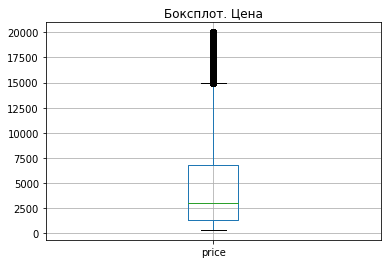

In [28]:
data.boxplot(column = 'price')
plt.title('Боксплот. Цена')
plt.show()

На боксплоте видим большое кол-во выбросов в верхней части. Это дорогие автомобили, будет не правильно их удалять т.к. они не являются аномальными.

Взглянем на статистику и графики года регистрации автомобиля.

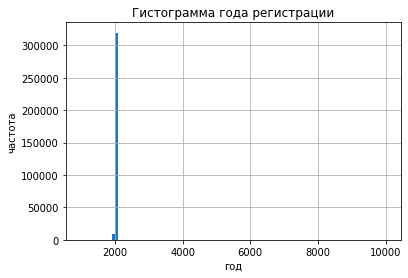

In [29]:
data['registration_year'].hist(bins=100)
plt.title('Гистограмма года регистрации')
plt.ylabel('частота')
plt.xlabel('год')
plt.show()

In [30]:
data['registration_year'].describe()

count    328024.000000
mean       2004.055755
std          67.546662
min        1000.000000
25%        1999.000000
50%        2003.000000
75%        2008.000000
max        9999.000000
Name: registration_year, dtype: float64

Для начала ограничим наши данные с 1899 по 2017 года.

In [31]:
data = data.query('1899 < registration_year < 2017')

In [32]:
data['registration_year'].describe()

count    314599.000000
mean       2002.784001
std           6.791133
min        1910.000000
25%        1999.000000
50%        2003.000000
75%        2007.000000
max        2016.000000
Name: registration_year, dtype: float64

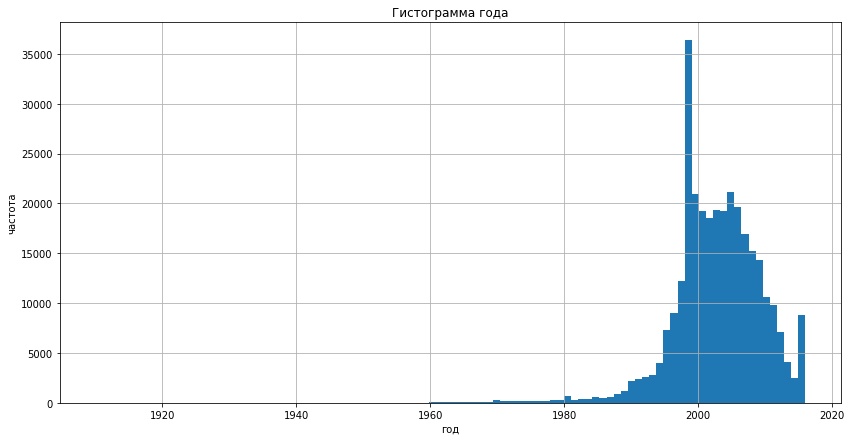

In [33]:
data['registration_year'].hist(bins=100, figsize=(14,7))
plt.title('Гистограмма года')
plt.ylabel('частота')
plt.xlabel('год')
plt.show()

Видим , что до 1970 года кол_во автамобилей очень мало, пожтому оставим данные только о машинах выпущенных позже.

In [34]:
data = data.query('1969 < registration_year')

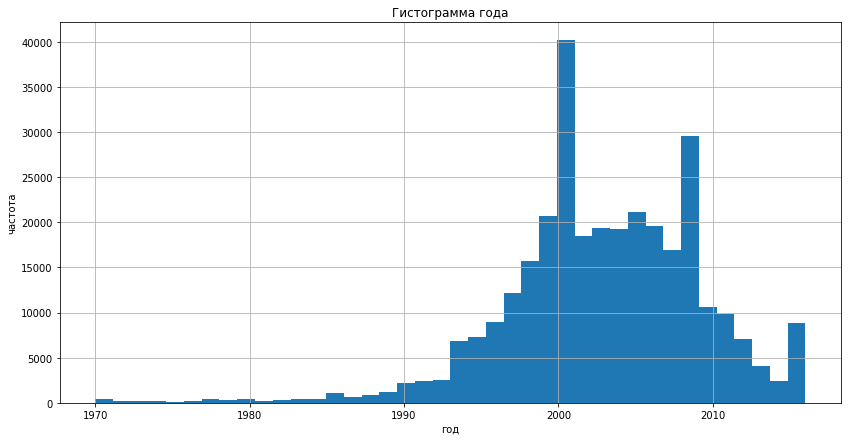

In [35]:
data['registration_year'].hist(bins=40, figsize=(14,7))
plt.title('Гистограмма года')
plt.ylabel('частота')
plt.xlabel('год')
plt.show()

Далее ознакомимся с мощностью двигателя.

In [36]:
data['power'].describe()

count    313564.000000
mean        114.618209
std         183.290823
min           0.000000
25%          75.000000
50%         107.000000
75%         144.000000
max       20000.000000
Name: power, dtype: float64

Для начала уберем из таблицы записи с мощностью двигателя равными 0.

In [37]:
data = data.query('0 < power')

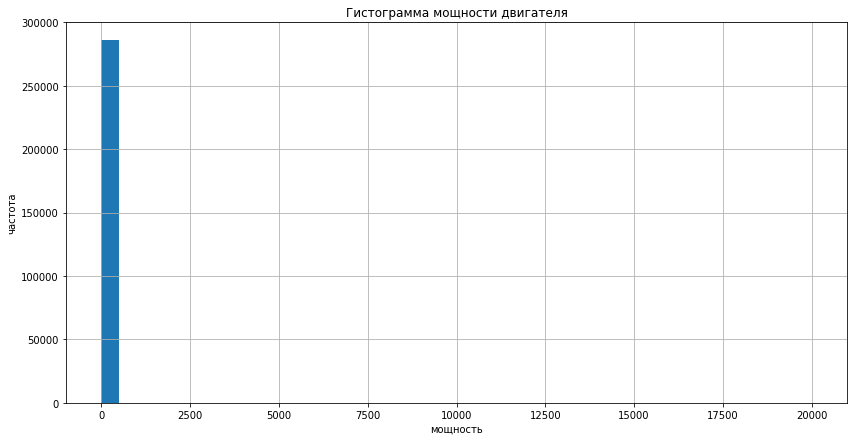

In [38]:
data['power'].hist(bins=40, figsize=(14,7))
plt.title('Гистограмма мощности двигателя')
plt.ylabel('частота')
plt.xlabel('мощность')
plt.show()

Ограничим максимальную мощность двтгателя в 900л.с.

In [39]:
data = data.query('power < 900')

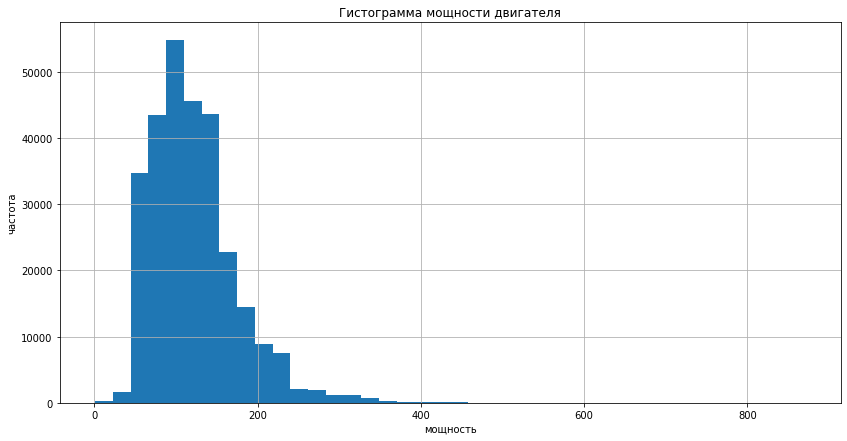

In [40]:
data['power'].hist(bins=40, figsize=(14,7))
plt.title('Гистограмма мощности двигателя')
plt.ylabel('частота')
plt.xlabel('мощность')
plt.show()

Возьмем окончательные границы для мощности: минимум 30 л.с. и 400л.с. как максимум. Эти значения выглядят наиболее адекватно для серийных автомобилей.

In [41]:
data = data.query('30 < power < 400')

In [42]:
data['power'].describe()

count    284761.000000
mean        121.868493
std          52.182591
min          31.000000
25%          80.000000
50%         115.000000
75%         150.000000
max         399.000000
Name: power, dtype: float64

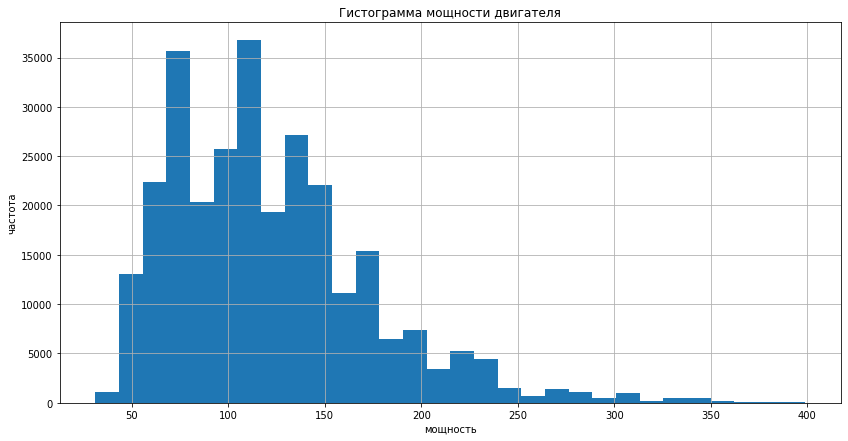

In [43]:
data['power'].hist(bins=30, figsize=(14,7))
plt.title('Гистограмма мощности двигателя')
plt.ylabel('частота')
plt.xlabel('мощность')
plt.show()

Посмотрим насколько сократилась наша таблица. 69608 наблюдений пришлось удалить.

In [44]:
data.shape

(284761, 10)

### Вывод по исследовательскому анализу.
1. Убрали записи с нулевым значением цены а также 0.5 квантиль.
2. Оставили в таблице машины зарегистрированные с 1969 по 2016 года.
3. Мощность двигателя ограничили от 30л.с. до 400л.с.

## Обучение моделей

Сейчас разделим датает на обучающую и тренировочную выборки и займемся заполнением пропусков в тренировочных данных. Пропуски в тестовых оставим как есть. Они иммитеруют новые данные.

Перед разбиением датасета нам необходимо избавиться от дубликатов, чтобы избежать просачивания данных.

In [45]:
data.duplicated().sum()

38202

In [46]:
data = data.drop_duplicates()

In [47]:
data.duplicated().sum()

0

In [48]:
# разделение датасета
X = data.drop(['price'], axis=1)
y = data['price']

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size = TEST_SIZE,
    random_state = RANDOM_STATE
)

Проверим размерности выборок. Разделение прошло успешно.

In [49]:
X_train.shape

(197247, 9)

In [50]:
X_test.shape

(49312, 9)

Проверим кол-во пропусков.

In [51]:
X_train.isna().sum()

vehicle_type          7074
registration_year        0
gearbox               3641
power                    0
model                 7588
kilometer                0
fuel_type            10595
brand                    0
repaired             28805
dtype: int64

В таблице много пропусков, постараемся их востановить.

In [52]:
X_train.loc[X_train['model'].isna(),'model'] = (X_train.groupby('brand')['model'].
                                          transform(lambda x: x.mode()[0] if not x.mode().empty else np.nan))

In [53]:
X_train[X_train['model'].isna()].head()

,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired
168062,convertible,1971,manual,50,NaN,50000,NaN,sonstige_autos,yes
10320,convertible,2013,manual,160,NaN,10000,petrol,sonstige_autos,no
190597,NaN,2016,manual,140,NaN,150000,NaN,sonstige_autos,no
216829,sedan,2008,auto,360,NaN,150000,petrol,sonstige_autos,no
141237,suv,1997,auto,140,NaN,150000,petrol,sonstige_autos,NaN


In [54]:
X_train[(X_train['model'].isna())&(X_train['brand'] == 'sonstige_autos')]['brand'].count()

1068

In [55]:
X_train.loc[(X_train['model'].isna()) & (X_train['brand'] == 'sonstige_autos'), 'model'] = 'unknown'

Пропуски в столбце смоделью машины заполнили модой в разбивке по бренду. Так же у бренда "'sonstige_autos" все значения моделей были пропусками, их заполнили заглужкой.

In [56]:
X_train.loc[X_train['vehicle_type'].isna(),'vehicle_type'] = (X_train.groupby('model')['vehicle_type'].
                                                        transform(lambda x: x.mode()[0] if not x.mode().empty else np.nan))

In [57]:
X_train.loc[X_train['gearbox'].isna(),'gearbox'] = (X_train.groupby('model')['gearbox'].
                                              transform(lambda x: x.mode()[0] if not x.mode().empty else np.nan))

In [58]:
X_train.loc[X_train['fuel_type'].isna(),'fuel_type'] = (X_train.groupby('model')['fuel_type'].
                                                  transform(lambda x: x.mode()[0] if not x.mode().empty else np.nan))

Столбцы "vehicle_type", "gearbox" и "fuel_type" заполнили по тому же принципу.

In [59]:
X_train.loc[data['repaired'].isna(), 'repaired'] = 'no'

Столбец с наличием ремонта заполнили как 'no'.

In [60]:
X_train.isna().sum()

vehicle_type         0
registration_year    0
gearbox              0
power                0
model                0
kilometer            0
fuel_type            0
brand                0
repaired             0
dtype: int64

Обработали все пропуски.

In [61]:
X_train.duplicated().sum()

104077

In [62]:
X_train = X_train.drop_duplicates()

После всех этапов обработки в датасете 95860 дубликатов. Удалим их. Если их оставить результаты моделей улучшаются незначительно, но время обучения увеличивается заметно.

In [63]:
X_train.shape

(93170, 9)

89059 столько наблюдений осталось в таблице. Теперь нужно оставить в y_train только те записи, которые соотносятся с тренировочными входными признаками.

In [64]:
y_train = y_train.loc[X_train.index]

In [65]:
y_train.shape

(93170,)

Данные готовы. Теперь создадим функцию, которая будет принимать данные и словарь с моделями и гипрмараметрами к ним. Внутри функции будет использоваться пайплайн по обработке признаков.

In [66]:
def create_model(X_train, X_test, y_train, y_test, param_grid, encoder_type):
    
    ohe_columns = ['vehicle_type','gearbox','model','fuel_type','brand','repaired']
    num_columns = ['registration_year','power','kilometer']
    # создаём пайплайн для подготовки признаков из списка ohe_columns: заполнение пропусков и OHE-кодирование
    if encoder_type == 'OneHotEncoder':
        # создаём пайплайн для подготовки признаков из списка ohe_columns: заполнение пропусков и OHE-кодирование
        # SimpleImputer + OneHotEncoder
        ohe_pipe = Pipeline(
        [('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
         ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False))
        ])
    elif encoder_type == 'OrdinalEncoder':
        # создаём пайплайн для подготовки признаков из списка ohe_columns: заполнение пропусков и Ordinal-кодирование
        # SimpleImputer + OrdinalEncoder
        ohe_pipe = Pipeline(
        [('simpleImputer_ordinal', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
         ('ordinal', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=np.nan))
        ])
    else:
        raise ValueError("Invalid encoder_type. Please choose 'OneHotEncoder' or 'OrdinalEncoder'.")

    # создаём общий пайплайн для подготовки данных
    data_preprocessor = ColumnTransformer(
        [('ohe', ohe_pipe, ohe_columns),
         ('num', MinMaxScaler(), num_columns)
        ], 
        remainder='passthrough'
    )
    
    # создаём итоговый пайплайн: подготовка данных и модель
    pipe_final = Pipeline([
        ('preprocessor', data_preprocessor),
        ('models', DecisionTreeRegressor(random_state=RANDOM_STATE))
    ])
    randomized_search = RandomizedSearchCV(
    pipe_final,
    param_grid,
    cv=5,
    scoring='neg_root_mean_squared_error',
    random_state=RANDOM_STATE,
    n_iter = 4,
    n_jobs = -1
    )
    
    randomized_search.fit(X_train, y_train)
    
    print('Модель и её параметры:\n\n', randomized_search.best_estimator_)
    print ('Метрика RMSE лучшей модели на тренировочной выборке:', randomized_search.best_score_*-1)
    y_test_pred = randomized_search.predict(X_test)
    print(f'Метрика RMSE на тестовой выборке: {mean_squared_error(y_test, y_test_pred, squared=False)}')
    best_fit_time = randomized_search.cv_results_['mean_fit_time'][randomized_search.best_index_]
    print(f'Среднее время обучения лучшей модели: {best_fit_time} сек')
    best_score_time = randomized_search.cv_results_['mean_score_time'][randomized_search.best_index_]
    print(f'Среднее время предсказания лучшей модели: {best_score_time} сек')


### DecisionTreeRegressor()
Обучим первую модель - решающее дерево.

In [67]:
# словарь для модели DecisionTreeRegressor()
tree_param_grid = [
    
    {
        'models': [DecisionTreeRegressor(random_state=RANDOM_STATE)],
        'models__max_depth': range(2,5),
        'models__max_features': range(2,5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    }]

In [68]:
create_model(X_train, X_test, y_train, y_test, tree_param_grid, 'OrdinalEncoder')

Модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ordinal',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ordinal',
                                                                   OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                  unknown_value=nan))]),
                                                  ['vehicle_type', 'gearbox',
                                                   'model', 'fuel_type',
                                                   'brand', 'repaired']),
                                                 ('num', StandardScaler(),
                       

Решающее дерево не смогло добиться желаемого результата - RMSE 2500.

### LinearRegression()
Теперь будем использовать три варианта линейной модели: LinearRegression, Lasso и Ridge.

In [69]:
linear_param_grid = [
    
    # словарь для модели LinearRegression()
    {
        'models': [LinearRegression()],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
    
    # словарь для модели Lasso()
    {
        'models': [Lasso(random_state=RANDOM_STATE)],
        'models__alpha': range(0,10),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  

    },
    
    
    # словарь для модели Ridge()
    {
        'models': [Ridge(random_state=RANDOM_STATE)],
        'models__alpha': range(0,10),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  

    }]

In [70]:
create_model(X_train, X_test, y_train, y_test, linear_param_grid, 'OneHotEncoder')

/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:228: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:228: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:228: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:228: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['vehicle_type', 'gearbox',
                                                   'model', 'fuel_type',
                                                   'brand', 'repaired']),
                      

/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:228: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Метрика RMSE на тестовой выборке: 2630.4668277023293
Среднее время обучения лучшей модели: 1.5736043930053711 сек
Среднее время предсказания лучшей модели: 0.31373324394226076 сек


Модель Ridge справилась лучше чем решающее дерево метрика RMSE на тестовой выборке: 2632.95162230641, но это так же не удовлетворяет требованиям задачи.

### LGBMRegressor()
Обучим модель на основе LGBM.

In [71]:
lgbm_param_grid = {
    'models': [LGBMRegressor(random_state=RANDOM_STATE)],
    'models__num_leaves': [20, 30, 40],
    'models__learning_rate': [0.01, 0.05, 0.1],
}

In [72]:
create_model(X_train, X_test, y_train, y_test, lgbm_param_grid, 'OrdinalEncoder')

Модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ordinal',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ordinal',
                                                                   OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                  unknown_value=nan))]),
                                                  ['vehicle_type', 'gearbox',
                                                   'model', 'fuel_type',
                                                   'brand', 'repaired']),
                                                 ('num', MinMaxScaler(),
                         

LGBM справилась с поставленной задачей - метрика RMSE на тестовой выборке: 1695.8212555062303 При этом среднее время обучения лучшей модели составило 2.860456943511963 сек, а среднее время предсказания лучшей модели: 0.22123756408691406  сек.

## Общий вывод.

В ходе работы были выполнены следующие шаги:<br>
<br>
1. Подготовка данных:<br>
1) Загрузили данные и провели первичное ознакомление.<br>
2) Выяснили, что 2016 год - это ферхняя граница регистрации автомобилей, соотвественно в таблице должны быть автомобили производства до 2016 года.<br>
3) Удалили 4 явных дубликата.<br>
4) Убрали неинформативные столбцы.<br>
5) Привели названия столбцов к нижнему регистру.<br>
6) Обнаружили большое кол-во пропусков в таблице, их обработкой займемся после разбиения на тестовую и тренировочную выборки.<br>
7) Проверили уникальные значения в категориальных столбцах. Заменили "cng" и "lpg" на "gasoline" т.к. это тоже газовое топливо.<br>
<br>
2. Исследовательский анализ:<br>
1) Убрали записи с нулевым значением цены а также 0.5 квантиль.<br>
2) Оставили в таблице машины зарегистрированные с 1969 по 2016 года.<br>
3) Мощность двигателя ограничили от 30л.с. до 400л.с.<br>
3. Обучение моделей:<br>
1) Удалили дубликаты перед разделением таблицы на тестовую и тренировучную выборки.<br>
2) После разбияния заполнили пропуски в тренировочных данных и удалили дубликаты.<br>
3) Обучили три твида молей - DecisionTreeRegressor, три линейных модели и модель градиентного бустинга LGBMRegressor. <br>
<br>
Именно модель градиентного бустинга показала себя лучше остальных:  метрика RMSE на тестовой выборке: 1695.8212555062303 при требование RMSE < 2500, среднее время обучения лучшей модели составило 2.860456943511963 сек, а среднее время предсказания лучшей модели: 0.22123756408691406 сек.